In [ ]:

import pandas as pd
import numpy as np
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
#from sklearn.metrics import mean_absolute_percentage_error


#from skforecast.ForecasterAutoreg import ForecastAutoreg
#from skforecast.ForecasterAutoregMultiOutput import ForecastAutoregMultiOutput
#from skforecast.model_election import grid_search_forecaster, time_series_spliter, cv_forecaster, backtesting_forecaster, backtesting_forecasting_intervals

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/glucose/all.csv', low_memory=False)
df['id'] = df['id'].astype('string')
df['datetime'] = pd.to_datetime(df['datetime'])

In [ ]:
df.head()

,date,time,glucose,type,comments
0,2014-10-01,19:14:00,10.3,cgm,NaN
1,2014-10-01,19:19:00,9.9,cgm,NaN
2,2014-10-01,19:23:00,9.4,manual,NaN
3,2014-10-01,19:24:00,9.8,cgm,NaN
4,2014-10-01,19:29:00,9.6,cgm,NaN


In [ ]:
#Conversión del formato fecha
df['Time'] = df['date'] + ' ' + df['time']
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('Time')
df = df.asfreq('5min')
df = df.sort_index()
df.head()

,date,time,glucose,type,comments
Time,,,,,
2014-10-01 19:14:00,2014-10-01,19:14:00,10.3,cgm,NaN
2014-10-01 19:19:00,2014-10-01,19:19:00,9.9,cgm,NaN
2014-10-01 19:24:00,2014-10-01,19:24:00,9.8,cgm,NaN
2014-10-01 19:29:00,2014-10-01,19:29:00,9.6,cgm,NaN
2014-10-01 19:34:00,2014-10-01,19:34:00,9.4,cgm,NaN


In [ ]:
del df['type']
del df['comments']

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.head()

,date,time,glucose
Time,,,
2014-10-01 19:14:00,2014-10-01,19:14:00,10.3
2014-10-01 19:19:00,2014-10-01,19:19:00,9.9
2014-10-01 19:24:00,2014-10-01,19:24:00,9.8
2014-10-01 19:29:00,2014-10-01,19:29:00,9.6
2014-10-01 19:34:00,2014-10-01,19:34:00,9.4


In [ ]:
#Transformar unidades de la medida de glucosa. mmol/l = 18 mg/dl
df['glucose'] = df['glucose']*18

In [ ]:
df.isnull().sum()

date       0
time       0
glucose    0
dtype: int64

In [ ]:

del df['date']
del df['time']

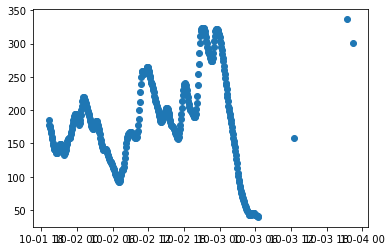

In [ ]:
df.reset_index(inplace=True)
plt.scatter(x=df.Time, y=df.glucose);

In [ ]:
df.tail()

,Time,glucose
422,2014-10-03 06:24:00,41.4
423,2014-10-03 06:29:00,39.6
424,2014-10-03 12:34:00,158.4
425,2014-10-03 21:24:00,336.6
426,2014-10-03 22:24:00,300.6


In [ ]:
print(df.Time.min())
print(df.Time.max())

2014-10-01 19:14:00
2014-10-03 22:24:00


In [ ]:
#Los tres últimos puntos no siguen la serie temporal. Los eliminamos
df = df[:-3]

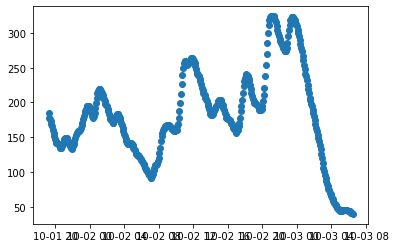

In [ ]:
plt.scatter(x=df.Time, y=df.glucose);

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('Time')
df = df.asfreq('5min')
df = df.sort_index()

In [ ]:
#Verificar que un índice temporal está completo
(df.index == pd.date_range(start= df.index.min(),
                          end = df.index.max(),
                          freq = df.index.freq)).all()

True

In [ ]:
print(df.index.min())
print(df.index.max())

2014-10-01 19:14:00
2014-10-03 06:29:00


In [ ]:
len(df)

424

In [ ]:
df.head()

,glucose
Time,
2014-10-01 19:14:00,185.4
2014-10-01 19:19:00,178.2
2014-10-01 19:24:00,176.4
2014-10-01 19:29:00,172.8
2014-10-01 19:34:00,169.2


In [ ]:
df[df.index < '2014-10-03 03:29:00']

,glucose
Time,
2014-10-01 19:14:00,185.4
2014-10-01 19:19:00,178.2
2014-10-01 19:24:00,176.4
2014-10-01 19:29:00,172.8
2014-10-01 19:34:00,169.2
...,...
2014-10-03 03:04:00,106.2
2014-10-03 03:09:00,100.8
2014-10-03 03:14:00,95.4


In [ ]:
datos_train = df[df.index < '2014-10-03 03:29:00']
datos_test = df[df.index >= '2014-10-03 03:29:00']

print(f"Fechas train: {datos_train.index.min()} --- {datos_train.index.max()}")
print(f"Fechas test: {datos_test.index.min()} --- {datos_test.index.max()}")

Fechas train: 2014-10-01 19:14:00 --- 2014-10-03 03:24:00
Fechas test: 2014-10-03 03:29:00 --- 2014-10-03 06:29:00


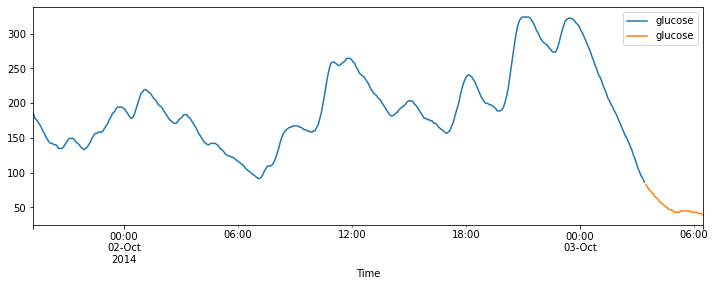

In [ ]:
# Gráfico division de nuestro test y train

fig, ax = plt.subplots(figsize=(12, 4))
datos_train.plot(ax=ax, label='train')
datos_test.plot(ax=ax, label='test')
ax.legend();

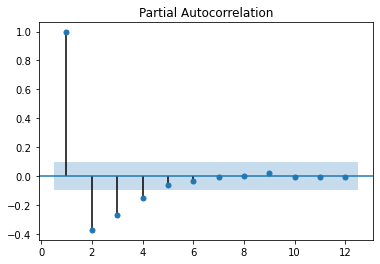

In [ ]:
# Grafico autocorrelacion

plot_pacf(df, lags=12, zero=False)
plt.plot();

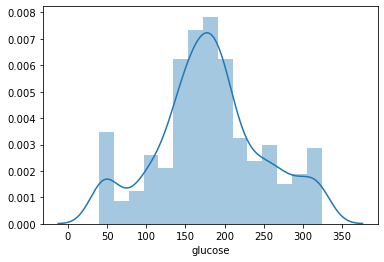

In [ ]:
sns.distplot(df['glucose'])

In [ ]:
df.reset_index(inplace=True)

df['lag2'] = df['glucose'].shift(2)
df['lag3'] = df['glucose'].shift(3)

df.dropna(inplace=True)
df.head()


,Time,glucose,lag2,lag3
3,2014-10-01 19:29:00,172.8,178.2,185.4
4,2014-10-01 19:34:00,169.2,176.4,178.2
5,2014-10-01 19:39:00,165.6,172.8,176.4
6,2014-10-01 19:44:00,160.2,169.2,172.8
7,2014-10-01 19:49:00,156.6,165.6,169.2


In [ ]:
X.shape

(421, 2)

In [ ]:
from sklearn.model_selection import train_test_split
X,y = df[['lag3', 'lag2']], df['glucose']


X_train, X_test, y_train, y_test = X[:382], X[382:], y[:382], y[382:]

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Scaled_train = scaler.fit_transform(X_train)

Scaled_test = scaler.transform(X_test)

In [ ]:
modelo = LinearRegression()
modelo.fit(Scaled_train, y_train)

LinearRegression()

In [ ]:
predictions_rl = modelo.predict(Scaled_test)

In [ ]:
results = pd.DataFrame(y_test)
results['predictions_rl'] = predictions_rl
rmse_rl = mean_squared_error(y_test, predictions_rl, squared=False)
results['rmse_rl'] = rmse_rl
r2_rl = r2_score(y_test, predictions_rl)
results['r2_rl'] = r2_rl
results.head()

,glucose,predictions_rl,rmse_rl,r2_rl
385,91.8,92.582533,2.807243,0.961339
386,86.4,87.266599,2.807243,0.961339
387,82.8,86.931517,2.807243,0.961339
388,79.2,78.406709,2.807243,0.961339
389,75.6,78.071626,2.807243,0.961339


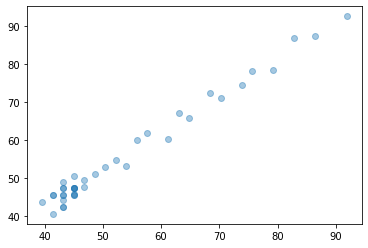

In [ ]:
plt.scatter(results.glucose, results.predictions_rl, alpha=.4)

In [ ]:
reg = RandomForestRegressor(max_depth=10, random_state=0)
reg.fit(Scaled_train,y_train)

RandomForestRegressor(max_depth=10, random_state=0)

In [ ]:
predictions_rf = reg.predict(Scaled_test)

In [ ]:
results['predictions_rf'] = predictions_rf
rmse_rf = mean_squared_error(y_test, predictions_rf, squared=False)
results['rmse_rf'] = rmse_rf
r2_rf = r2_score(y_test, predictions_rf)
results['r2_rf'] = r2_rf
results.head()

,glucose,predictions_rl,rmse_rl,r2_rl,predictions_rf,rmse_rf,r2_rf
385,91.8,92.582533,2.807243,0.961339,97.749,46.451011,-9.585418
386,86.4,87.266599,2.807243,0.961339,93.132,46.451011,-9.585418
387,82.8,86.931517,2.807243,0.961339,93.168,46.451011,-9.585418
388,79.2,78.406709,2.807243,0.961339,98.082,46.451011,-9.585418
389,75.6,78.071626,2.807243,0.961339,98.082,46.451011,-9.585418


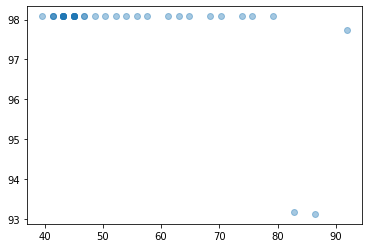

In [ ]:
plt.scatter(results.glucose, results.predictions_rf, alpha=.4)

In [ ]:
df.head()

,Time,glucose,lag2,lag3
3,2014-10-01 19:29:00,172.8,178.2,185.4
4,2014-10-01 19:34:00,169.2,176.4,178.2
5,2014-10-01 19:39:00,165.6,172.8,176.4
6,2014-10-01 19:44:00,160.2,169.2,172.8
7,2014-10-01 19:49:00,156.6,165.6,169.2


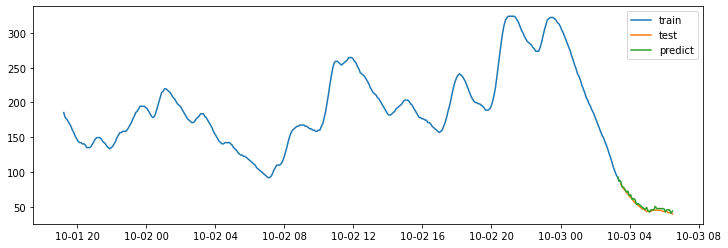

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(datos_train, label='train')
plt.plot(datos_test, label='test')

x = df.Time[382:]

plt.plot(x, results.predictions_rl, label='predict')
ax.legend();

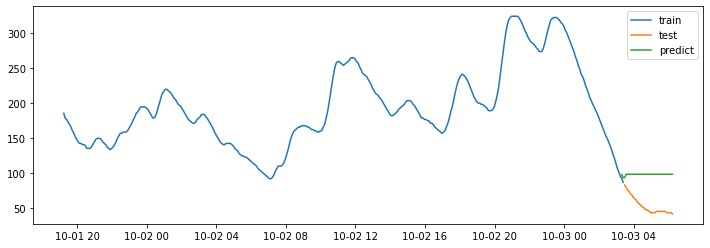

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(datos_train, label='train')
plt.plot(datos_test, label='test')

x = df.Time[382:]

plt.plot(x, results.predictions_rf, label='predict')
ax.legend();